# Only adaptive RAG (Evaluation)

Loaded 1 URLs from 'config/BASE_URL.csv'.
The folder 'faiss' already exists.
Loading existing FAISS index from disk...
The graph has been saved as 'graph.png'.


### LangGraph Visualization ###

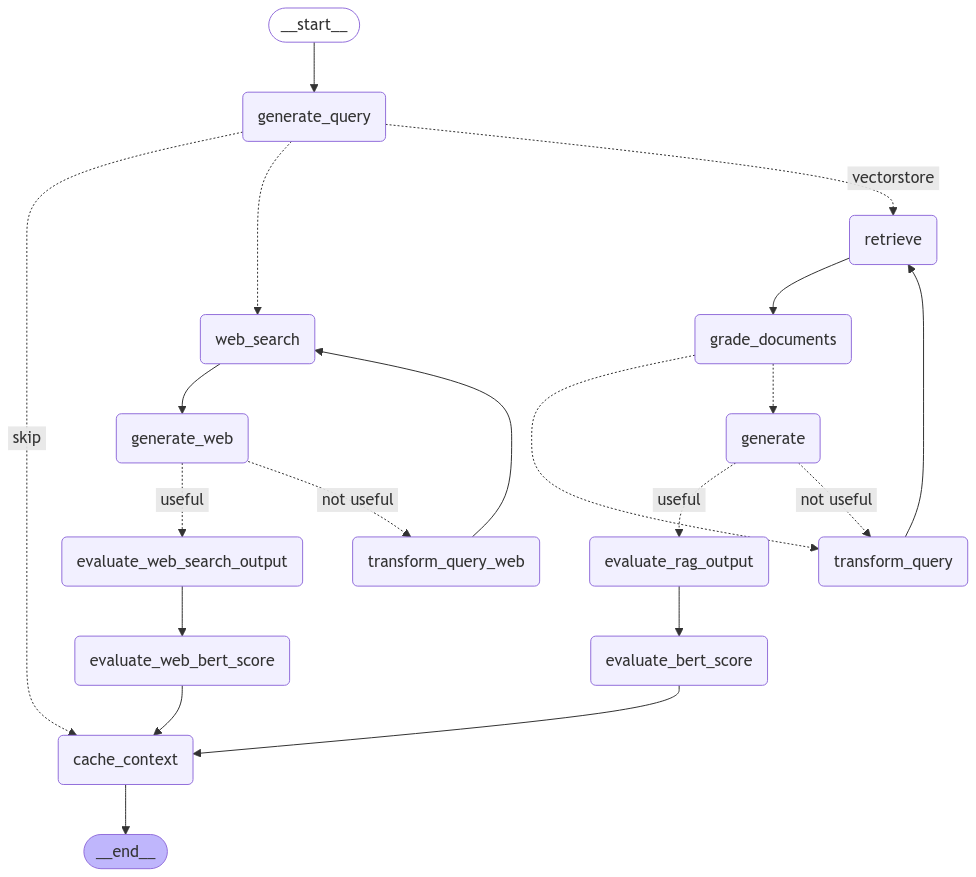

In [276]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

###################################
#           LIBRARIES             #
###################################

import os
import json
import csv
import time
import uuid
import faiss
import numpy as np
import torch
import textdistance
from sentence_transformers import SentenceTransformer
from bs4 import BeautifulSoup
import requests
import xml.etree.ElementTree as ET  # For parsing the Ecore file

from codecarbon import EmissionsTracker  # Import CodeCarbon

# LangChain and related libraries
from langchain.prompts.chat import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI
from langchain.llms import Ollama
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.callbacks.base import BaseCallbackHandler
from langchain.tools.base import Tool
from typing import Callable

###################################
#         CONFIGURATION           #
###################################

# Configuration file paths (llm_config_anthropic, llm_config_google, llm_config_groq, llm_config_mistral, llm_config_ollama, llm_config_openai)
# CONFIG_FILE = "config/llm_config_openai.json"
MODELS_FILE = "config/llm_models.json"
CONFIG_RAG_FILE = "config/llm_config_ollama_rag.json"
CONFIG_RAG_TAVILY_FILE = "config/secrets-master-llm.json"
VECTOR_DB_TYPE = "FAISS" # FAISS, CHROMA
CSV_FILE_PATH = "config/BASE_URL.csv"
LLM_TYPE = 'Ollama' # 'Others', 'Ollama'
RAG_CHAT = 'LangChain' # 'OpenAI', 'Mistral', 'LangChain' (Same Model as the Trace Generation)
TYPE_RETRIEVER = 'web' # 'web', 'chroma', 'faiss'

# Define an array with all the topics/tools for retrieval
vectorstore_topics = ["Cristiano Ronaldo"] # , "N.D.", "N.F."

    # "CAEX/AutomationML",
    # "BPMN Designer",
    # "HEPSYCODE",
    # "Additional Tool 1",
    # "Additional Tool 2",
    # Add more topics as needed

###################################
#         UTILITY FUNCTIONS       #
###################################

# Function to load configuration from a JSON file
def load_config(config_file):
    try:
        with open(config_file, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"Configuration file {config_file} not found.")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return {}

# Function to load file content
def load_file_content(file_path):
    try:
        with open(file_path, 'r') as file:
            return file.read()
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return ""

# Function to save content to a file
def save_to_file(file_path, content):
    with open(file_path, 'w') as file:
        file.write(content)

# Function to save metadata to a file (in JSON format)
def save_metadata(file_path, metadata):
    with open(file_path, 'w') as file:
        json.dump(metadata, file, indent=4)

###################################
#         LLM CONFIGURATION       #
###################################

# Load LLM configuration
config = load_config(CONFIG_RAG_FILE)
models_config = load_config(MODELS_FILE)

# Extract LLM parameters from configuration
LLM = config.get("llm")
if not LLM:
    raise ValueError("LLM name must be specified in the configuration file.")

PRICE_PER_INPUT_TOKEN = config.get("price_per_input_token")
PRICE_PER_OUTPUT_TOKEN = config.get("price_per_output_token")
temperature = config.get("temperature")
max_retries = config.get("max_retries")
api_key = config.get("api_keys", {}).get(LLM.lower(), None)
base_url = config.get("base_url")

# Determine LLM type and initialize LLM instance
llm_config = models_config.get(LLM, None)
if llm_config and LLM_TYPE != 'Ollama':
    llm_params = llm_config.get("params", {})
    llm_params["temperature"] = temperature
    llm_params["max_retries"] = max_retries
    llm_params["api_key"] = api_key
    llm_params["base_url"] = base_url

    # Dynamically initialize the LLM class
    llm_class = eval(llm_config["class"])
    llm_LangChain = llm_class(**llm_params)
    model_name = LLM  # Use LLM name as the model name
elif LLM_TYPE == 'Ollama':
    llm_params = llm_config.get("params", {})
    llm_params["temperature"] = temperature
    llm_params["base_url"] = base_url

    llm_class = eval(llm_config["class"])
    llm_LangChain = llm_class(**llm_params)
    model_name = LLM
else:
    raise ValueError(f"Model configuration for '{LLM}' not found in {MODELS_FILE}.")

###################################
#     FEW-SHOT CONFIGURATION      #
###################################

# Define file paths for static resources and output directories
# example_model_path = "../../01-02-03_MSE/HEPSYCODE/HEPSYCODE-Models/D1/HEPSY/2024-02-14 18.30 13%20-%20FIRFIRGCD_HPV-representations.aird.hepsy"
# example_xes_trace_path = "../../04_Trace_Parser/D1_HEPSYCODE/XES-MORGAN/2024-02-14 18.30 13%20-%20FIRFIRGCD_HPV-representations.aird.xes"

# Path to the metamodel (Ecore file)
metamodel_path = "../../01-02-03_MSE/HEPSYCODE/org.univaq.hepsy/model/hepsy.ecore"

# Path to the model folders (Hepsy file)
# base_model_path = "../../01-02-03_MSE/HEPSYCODE/HEPSYCODE-Models/D1/HEPSY/"

# Path to the Output Directory
base_output_dir = f"D2-HEPSYCODE-RAG-EVAL/{TYPE_RETRIEVER}/XES-MORGAN-RAG-LLM-{model_name.lower()}-{temperature}"
base_output_json_dir = f"D2-HEPSYCODE-RAG-EVAL/{TYPE_RETRIEVER}/XES-MORGAN-RAG-LLM-{model_name.lower()}-{temperature}/JSON"

# Profiling Folder
PROFILING_FOLDER = f"D2-HEPSYCODE-RAG-EVAL/{TYPE_RETRIEVER}/XES-MORGAN-RAG-LLM-{model_name.lower()}-{temperature}/JSON"
if not os.path.exists(PROFILING_FOLDER):
    os.makedirs(PROFILING_FOLDER)
PROFILING_CSV_FILE = os.path.join(PROFILING_FOLDER, "profiling.csv")

# CodeCarbon Folder
CODECARBON_FOLDER  = f"D2-HEPSYCODE-RAG-EVAL/{TYPE_RETRIEVER}/XES-MORGAN-RAG-LLM-{model_name.lower()}-{temperature}/JSON"
if not os.path.exists(CODECARBON_FOLDER ):
    os.makedirs(CODECARBON_FOLDER )
PROFILING_CSV_FILE = os.path.join(PROFILING_FOLDER, "codecarbon_summary.csv")

# Folder to save evaluation results per file
EVALUATION_FOLDER = f"D2-HEPSYCODE-RAG-EVAL/{TYPE_RETRIEVER}/XES-MORGAN-RAG-LLM-{model_name.lower()}-{temperature}/JSON"
if not os.path.exists(EVALUATION_FOLDER):
    os.makedirs(EVALUATION_FOLDER)

# Global variable to force context regeneration regardless of REFINED_CONTEXT_PATH presence
FORCE_CONTEXT_GEN = True  # Set to True to force context generation even if REFINED_CONTEXT_PATH exists

# File path to save the refined context (persistent cache)
REFINED_CONTEXT_PATH = f"D2-HEPSYCODE-RAG-EVAL/{TYPE_RETRIEVER}/XES-MORGAN-RAG-LLM-{model_name.lower()}-{temperature}/HEPSYCODE_refined_context.json"
# REFINED_CONTEXT_PATH = "config/CAEX_refined_context.json"
# REFINED_CONTEXT_PATH = "config/BPMN_Designer_refined_context.json"

###################################
#         GLOBAL PROFILING        #
###################################

# Global list to collect CodeCarbon metrics for each node call (per file)
cc_metrics_for_file = []  # This will be reset for each file

# Global list for overall CodeCarbon summary per file
cc_summary_records = []

# Global list to save profiling data
profiling_records = []

###################################
#      TIMING NODE PROFILING      #
###################################

def timing_profile_node(func):
    """
    Decorator to profile a node function.
    Appends a record with the node name and its execution time (in seconds) to profiling_records.
    """
    def wrapper(state, *args, **kwargs):
        start = time.time()
        result = func(state, *args, **kwargs)
        end = time.time()
        elapsed = end - start
        profiling_records.append({"node": func.__name__, "execution_time": elapsed})
        print(f"[Profiling] {func.__name__} took {elapsed:.4f} seconds")
        return result
    return wrapper

###################################
#    CODECARBON NODE DECORATOR    #
###################################

# os.environ["CODECARBON_API_KEY"] = "CODECARBON_API_KEY"
# os.environ["CODECARBON_API_URL"] = "https://api.codecarbon.io"
# os.environ["CODECARBON_EXPERIMENT_ID"] = "UUID"

def cc_profile_node(func):
    """
    Decorator that wraps a node function with CodeCarbon tracking.
    It starts a tracker before calling the node and stops it right after.
    The resulting metrics are appended to the global cc_metrics_for_file list.
    """
    def wrapper(state, *args, **kwargs):
        # Create a CodeCarbon tracker for this node
        tracker = EmissionsTracker(
            project_name=f"cc_{func.__name__}",
            measure_power_secs=1,
            output_dir=CODECARBON_FOLDER,  # You can adjust output_dir as needed (".")
            allow_multiple_runs=True
            # api_call_interval=4,
            # experiment_id=experiment_id,
            # save_to_api=True
        )
        tracker.start()
        result = func(state, *args, **kwargs)
        emissions = tracker.stop()
        # Try to extract detailed metrics if available (from the internal attribute)
        if hasattr(tracker, "_final_emissions_data"):
            metrics = tracker._final_emissions_data
        else:
            metrics = {"total_emissions": emissions}
        # Append the node's CodeCarbon metrics to the global list
        cc_metrics_for_file.append({
            "node": func.__name__,
            **metrics  # Flatten the metrics dictionary
        })
        return result
    return wrapper

###################################
#       PROFILE & CC DECORATORS   #
###################################

# (Assuming you already have a @profile_node decorator for timing, as in your code.)
# Here we combine both decorators so that each node is profiled for time and CodeCarbon metrics.
# The order of decorators means that cc_profile_node will wrap the function first.
def profile_node(func):
    return timing_profile_node(cc_profile_node(func))

###################################
#       LOAD URLS FROM CSV        #
###################################

def load_urls_from_csv(csv_file_path):
    urls = []
    try:
        with open(csv_file_path, 'r', newline='', encoding='utf-8') as csv_file:
            reader = csv.reader(csv_file)
            for row in reader:
                if row:  # Ensure the row is not empty
                    urls.append(row[0].strip())
    except FileNotFoundError:
        print(f"Error: CSV file '{csv_file_path}' not found.")
    except Exception as e:
        print(f"Error reading CSV file: {e}")
    return urls

# Load base URLs for the vector database from CSV
BASE_URLS = load_urls_from_csv(CSV_FILE_PATH)
if not BASE_URLS:
    raise ValueError("No URLs were loaded from the CSV file.")
else:
    print(f"Loaded {len(BASE_URLS)} URLs from '{CSV_FILE_PATH}'.")

###################################
# RAG AGENT SETUP (Chroma/FAISS)  #
###################################

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS

if VECTOR_DB_TYPE == "CHROMA":
    # Directory for persisting the Chroma vector store.
    CHROMA_PERSIST_DIR = "chroma_db"
    
    # Load RAG configuration
    config_rag = load_config(CONFIG_RAG_FILE)
    api_key_rag = config_rag.get("api_keys", {}).get(LLM.lower(), None)
    
    # Initialize OpenAIEmbeddings
    embd = OpenAIEmbeddings(openai_api_key=api_key_rag)
    
    # Build or load the Chroma vector store
    if os.path.exists(CHROMA_PERSIST_DIR) and os.listdir(CHROMA_PERSIST_DIR):
        print("Loading existing Chroma vector store from disk...")
        vectorstore = Chroma(
            persist_directory=CHROMA_PERSIST_DIR,
            embedding_function=embd,
            collection_name="rag-chroma"
        )
        retriever = vectorstore.as_retriever()
    else:
        print("Creating new Chroma vector store...")
        docs = [WebBaseLoader(url).load() for url in BASE_URLS]
        docs_list = [item for sublist in docs for item in sublist]
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=500, chunk_overlap=0
        )
        doc_splits = text_splitter.split_documents(docs_list)
        vectorstore = Chroma.from_documents(
            documents=doc_splits,
            collection_name="rag-chroma",
            embedding=embd,
            persist_directory=CHROMA_PERSIST_DIR
        )
        retriever = vectorstore.as_retriever()
elif VECTOR_DB_TYPE == "FAISS":

    # Load RAG configuration
    config_rag = load_config(CONFIG_RAG_FILE)
    api_key_rag = config_rag.get("api_keys", {}).get(LLM.lower(), None)
    
    EMBEDDING_MODEL_NAME = "all-MiniLM-L6-v2"  
    HUGGINGFACE_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
    
    faiss_folder = "faiss"
    if not os.path.exists(faiss_folder):
        os.makedirs(faiss_folder)
        print(f"Folder '{faiss_folder}' created.")
    else:
        print(f"The folder '{faiss_folder}' already exists.")
    
    DATABASE_PATH = os.path.join(faiss_folder, "faiss_index.index")
    METADATA_PATH = os.path.join(faiss_folder, "metadata.json")
    
    embedding = HuggingFaceEmbeddings(model_name=HUGGINGFACE_MODEL_NAME)
    
    if os.path.exists(DATABASE_PATH):
        print("Loading existing FAISS index from disk...")
        vectorstore = FAISS.load_local(DATABASE_PATH, embedding, allow_dangerous_deserialization=True)
        if os.path.exists(METADATA_PATH):
            with open(METADATA_PATH, "r", encoding="utf-8") as f:
                metadata = json.load(f)
    else:
        print("Creating new FAISS vector store...")
        from langchain_community.document_loaders import WebBaseLoader
        docs = [WebBaseLoader(url).load() for url in BASE_URLS]
        docs_list = [item for sublist in docs for item in sublist]
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
        doc_splits = text_splitter.split_documents(docs_list)
        vectorstore = FAISS.from_documents(doc_splits, embedding)
        vectorstore.save_local(DATABASE_PATH)
        metadata = [doc.metadata for doc in doc_splits]
        with open(METADATA_PATH, "w", encoding="utf-8") as f:
            json.dump(metadata, f, indent=4)
        
    retriever = vectorstore.as_retriever()    

###################################
#         ROUTER NODE             #
###################################

from typing import Literal
from pydantic import BaseModel, Field

# Data model for routing the user query
class RouteQuery(BaseModel):
    datasource: Literal["web_search", "vectorstore"] = Field(
        ...,
        description="Route the user query to either a vectorstore or web search."
    )

# Initialize RAG LLM and router
LLM_RAG = config_rag.get("llm")
LLM_RAG_TEMP = config_rag.get("temperature")

if RAG_CHAT == 'OpenAI':
    llm_rag = ChatOpenAI(model=LLM_RAG, temperature=LLM_RAG_TEMP)
elif RAG_CHAT == 'LangChain':
    llm_rag = OllamaFunctions(model=LLM) 
elif RAG_CHAT == 'Mistral':
    llm_rag = llm_LangChain

structured_llm_router = llm_rag.with_structured_output(RouteQuery)

# Join the topics into a single string, separated by commas
topics_str = ", ".join(vectorstore_topics)

# Create router prompt
router_system_prompt = (
    "You are an expert at routing user queries to either a vectorstore or web search. "
    "The vectorstore contains documents related to {topics_str}."
    "Use the vectorstore for questions on these topics; otherwise, use web search."
    "Based on the query, respond with a JSON object that contains a key 'datasource'"
    "whose value is either 'vectorstore' or 'web_search'. Do not include any additional keys or text."
)
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_system_prompt),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router

###################################
#      RETRIEVAL GRADER NODE      #
###################################

# Data model for grading document relevance
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Indicates whether the document is relevant ('yes' or 'no')."
    )

structured_llm_grader = llm_rag.with_structured_output(GradeDocuments)

grader_system_prompt = (
    "You are a grader assessing the relevance of a retrieved document to a user query. "
    "If the document contains keywords or semantic content related to the user query, grade it as relevant. "
    "Output a binary score 'yes' or 'no'."
)
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_system_prompt),
        ("human", "Retrieved document:\n\n{document}\n\nUser query:\n{question}"),
    ]
)
retrieval_grader = grade_prompt | structured_llm_grader

###################################
#        GENERATION CHAIN         #
###################################

from langchain_core.output_parsers import StrOutputParser
from langchain.globals import set_llm_cache
from langchain.cache import InMemoryCache

# Set up in-memory cache to avoid repeating expensive LLM calls.
set_llm_cache(InMemoryCache())

context_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are an expert in information retrieval and content synthesis. Your task is to refine and enhance context "
                "from multiple sources by generating a cohesive, well-structured, and detailed context that combines information "
                "from various retrieved documents.\n\n"
                "Responsibilities:\n"
                "1. Synthesize information from multiple sources into a unified explanation.\n"
                "2. Expand on the query with relevant details from the retrieved content.\n"
                "3. Format the refined context with clear structure and professional language.\n"
                "4. Incorporate metadata for traceability.\n"
            )
        ),
        (
            "user",
            (
                "Question: {question}\n\n"
                "The following are the retrieved documents and metadata:\n\n{context}\n\n"
                "Using this information, generate a refined and comprehensive context."
            )
        ),
    ]
)

if RAG_CHAT == 'OpenAI':
    llm_for_context = ChatOpenAI(model=LLM_RAG, temperature=LLM_RAG_TEMP)
elif RAG_CHAT == 'LangChain':
    llm_for_context = llm_LangChain
elif RAG_CHAT == 'Mistral':
    llm_for_context = llm_LangChain
    
rag_chain = context_prompt_template | llm_for_context | StrOutputParser()

###################################
#     HALLUCINATION GRADER        #
###################################

# Data model for grading hallucination
class GradeHallucinations(BaseModel):
    binary_score: str = Field(
        description="Indicates if the answer is grounded in facts ('yes' or 'no')."
    )

structured_llm_hallucination = llm_rag.with_structured_output(GradeHallucinations)

hallucination_system_prompt = (
    "You are a grader assessing whether the LLM generation is grounded in the retrieved facts. "
    "Output a binary score 'yes' if the answer is supported by the facts, otherwise 'no'."
)
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_system_prompt),
        ("human", "Facts:\n\n{documents}\n\nLLM Generation:\n{generation}"),
    ]
)
hallucination_grader = hallucination_prompt | structured_llm_hallucination

###################################
#         ANSWER GRADER           #
###################################

# Data model for grading answer relevance
class GradeAnswer(BaseModel):
    binary_score: str = Field(
        description="Indicates if the answer addresses the question ('yes' or 'no')."
    )

structured_llm_answer = llm_rag.with_structured_output(GradeAnswer)

answer_system_prompt = (
    "You are a grader assessing whether an LLM-generated answer addresses the user query. "
    "Output a binary score 'yes' if it does, otherwise 'no'."
)
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_system_prompt),
        ("human", "User Query:\n{question}\n\nLLM Generation:\n{generation}"),
    ]
)
answer_grader = answer_prompt | structured_llm_answer

###################################
#       QUESTION REWRITER         #
###################################

rewrite_system_prompt = (
    "You are a question rewriter. Given an input question, produce an improved version optimized for vectorstore retrieval. "
    "Focus on the underlying semantic intent."
)
rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rewrite_system_prompt),
        ("human", "Original question:\n{question}\n\nRewrite the question:"),
    ]
)
question_rewriter = rewrite_prompt | llm_for_context | StrOutputParser()

###################################
#           WEB SEARCH            #
###################################

from langchain_community.tools.tavily_search import TavilySearchResults
config_tavily = load_config(CONFIG_RAG_TAVILY_FILE)
os.environ["TAVILY_API_KEY"] = config_tavily.get("tavily_api_key")
web_search_tool = TavilySearchResults(k=3)

###################################
#       GRAPH STATE DEFINITION    #
###################################

from typing import List, Dict, Any
from typing_extensions import TypedDict

class GraphState(TypedDict, total=False): 
    question: str
    generation: str
    documents: List[Any]
    file_name: str      # For trace generation node
    context_llm: str    # The refined context
    trace_status: str
    xes_trace: str
    metadata: Dict[str, Any]
    branch: str         # Indicates the branch: "retrieve" or "web_search"
    evaluation_metrics: Dict[str, float]
    bert_score: Dict[str, float]
    web_bert_score: Dict[str, float]
    skip_router: bool   # If True, skip the routing and proceed directly to cache_context_node

###################################
# FUNCTION: GENERATE QUERY FROM METAMODEL #
###################################

@profile_node
def generate_query_from_metamodel(metamodel_path):
    """
    Reads the metamodel (Ecore file), extracts basic information (package name, nsURI, and classifiers),
    and constructs a query based solely on the extracted information.
    """
    try:
        tree = ET.parse(metamodel_path)
        root = tree.getroot()
        # The root is typically an EPackage with attributes
        package_name = root.attrib.get("name", "UnknownPackage")
        ns_uri = root.attrib.get("nsURI", "Unknown nsURI")
        # Extract all classifiers (e.g., EClass, EEnum, etc.)
        classifiers = []
        for classifier in root.findall("{http://www.eclipse.org/emf/2002/Ecore}eClassifiers"):
            classifiers.append(classifier.attrib.get("name", "UnnamedClassifier"))
        classifiers_str = ", ".join(classifiers) if classifiers else "None"
        # Build a generic query based solely on the metamodel information
        query = (
            f"Metamodel Analysis Query:\n"
            f"Package Name: {package_name}\n"
            f"Namespace URI: {ns_uri}\n"
            f"Classifiers: {classifiers_str}\n"
            "Based solely on the metamodel information provided above, generate a minimal context for a tool based on this metamodel. "
            "The context should only include the tool's name, which must be directly derived from the package name."
        )
        return query
    except Exception as e:
        print("Error generating query from metamodel:", e)
        return "Metamodel analysis query could not be generated."

# The query for generating the context is now created based on the metamodel
# question = generate_query_from_metamodel(metamodel_path)
# print(question)

###################################
#        EVALUATION NODES         #
###################################

# (1) LLM-based Evaluation for RAG output (vectorstore branch)
from pydantic import BaseModel, Field

class RAGEvaluationMetrics(BaseModel):
    faithfulness: float = Field(..., description="Score (0-1) indicating how faithful the answer is to the facts.")
    answer_relevance: float = Field(..., description="Score (0-1) indicating how well the answer addresses the question.")
    context_precision: float = Field(..., description="Score (0-1) representing the precision of the context used.")
    context_accuracy: float = Field(..., description="Score (0-1) representing the accuracy of the retrieved context.")
    context_recall: float = Field(..., description="Score (0-1) representing the recall of the context.")
    context_f1: float = Field(..., description="Score (0-1) representing the F1 measure of the context.")

@profile_node
def evaluate_rag_output(state: GraphState) -> GraphState:
    """
    Node to evaluate the RAG output (vectorstore branch) based on metrics such as:
    Faithfulness, Answer Relevance, Context Precision, Context Accuracy,
    Context Recall, and Context F1.
    """
    print("--- EVALUATE RAG OUTPUT METRICS ---")
    question_val = state.get("question", "")
    generation = state.get("generation", "")
    documents = state.get("documents", [])
    context_text = "\n".join([doc.page_content for doc in documents]) if documents else ""
    
    eval_input = {
         "question": question_val,
         "generation": generation,
         "context": context_text
    }
    
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", (
            "You are an expert evaluator of RAG outputs. Evaluate the output based on the following metrics: "
            "Faithfulness, Answer Relevance, Context Precision, Context Accuracy, Context Recall, and Context F1. "
            "For each metric, assign a score between 0 and 1. "
            "Respond in JSON format with keys: faithfulness, answer_relevance, context_precision, "
            "context_accuracy, context_recall, context_f1."
        )),
        ("user", "Question:\n{question}\n\nGenerated Answer:\n{generation}\n\nContext:\n{context}\n\nProvide the evaluation:")
    ])

    structured_eval = llm_rag.with_structured_output(RAGEvaluationMetrics)
    eval_chain = eval_prompt | structured_eval
    try:    
        eval_metrics = eval_chain.invoke(eval_input)
        state["evaluation_metrics"] = eval_metrics.dict()
        print("Evaluation metrics:", state["evaluation_metrics"])
    except Exception as e:
         print("Error during evaluation of RAG output:", e)
         state["evaluation_metrics"] = {}
    return state

# (2) BERTScore Evaluation for RAG output (vectorstore branch)
@profile_node
def evaluate_bert_score(state: GraphState) -> GraphState:
    print("--- EVALUATE BERT SCORE ---")
    try:
        from bert_score import score
    except ImportError:
        print("Please install bert-score using 'pip install bert-score'")
        state["bert_score"] = None
        return state

    candidate = state.get("generation", "")
    documents = state.get("documents", [])
    reference = "\n".join([doc.page_content for doc in documents]) if documents else ""
    
    if not candidate or not reference:
        print("Candidate or reference text is empty. Skipping BERTScore evaluation.")
        state["bert_score"] = None
        return state
    
    P, R, F1 = score([candidate], [reference], lang="en", verbose=True)
    bert_precision = P[0].item()
    bert_recall = R[0].item()
    bert_f1 = F1[0].item()
    state["bert_score"] = {"precision": bert_precision, "recall": bert_recall, "f1": bert_f1}
    print("BERTScore metrics:", state["bert_score"])
    return state

# (3) LLM-based Evaluation for Web Search output
# Here, we introduce an additional metric "accuracy" along with the previous ones.
class WebEvaluationMetrics(BaseModel):
    faithfulness: float = Field(..., description="Score (0-1) indicating how faithful the answer is to the web sources.")
    answer_relevance: float = Field(..., description="Score (0-1) indicating how well the answer addresses the query.")
    context_precision: float = Field(..., description="Score (0-1) representing the precision of the web search results.")
    context_accuracy: float = Field(..., description="Score (0-1) representing the accuracy of the retrieved web content.")
    context_recall: float = Field(..., description="Score (0-1) representing the recall of relevant web information.")
    context_f1: float = Field(..., description="Score (0-1) representing the F1 measure of the web search results.")
    accuracy: float = Field(..., description="Score (0-1) indicating the overall accuracy of the generated context based on web sources.")

@profile_node
def evaluate_web_search_output(state: GraphState) -> GraphState:
    """
    Node to evaluate the output of the web search branch.
    It uses the same metrics as the RAG evaluation plus an extra metric 'accuracy'.
    The reference is the concatenated web search source content.
    """
    print("--- EVALUATE WEB SEARCH OUTPUT METRICS ---")
    question_val = state.get("question", "")
    generation = state.get("generation", "")
    documents = state.get("documents", [])
    context_text = "\n".join([doc.page_content for doc in documents]) if documents else ""
    
    eval_input = {
         "question": question_val,
         "generation": generation,
         "context": context_text
    }
    
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", (
            "You are an expert evaluator of web search outputs. Evaluate the output based on the following metrics: "
            "Faithfulness, Answer Relevance, Context Precision, Context Accuracy, Context Recall, Context F1, and Accuracy. "
            "For each metric, assign a score between 0 and 1. "
            "Respond in JSON format with keys: faithfulness, answer_relevance, context_precision, "
            "context_accuracy, context_recall, context_f1, accuracy."
        )),
        ("user", "Question:\n{question}\n\nGenerated Answer/Context:\n{generation}\n\nWeb Search Sources:\n{context}\n\nProvide the evaluation:")
    ])
    
    structured_eval = llm_rag.with_structured_output(WebEvaluationMetrics)
    eval_chain = eval_prompt | structured_eval
    try:  
        eval_metrics = eval_chain.invoke(eval_input)
        state["evaluation_metrics"] = eval_metrics.dict()
        print("Web search evaluation metrics:", state["evaluation_metrics"])
    except Exception as e:
         print("Error during web search evaluation:", e)
         state["evaluation_metrics"] = {}
    return state

# (4) BERTScore Evaluation for Web Search output
@profile_node
def evaluate_web_bert_score(state: GraphState) -> GraphState:
    print("--- EVALUATE WEB BERT SCORE ---")
    try:
        from bert_score import score
    except ImportError:
        print("Please install bert-score using 'pip install bert-score'")
        state["web_bert_score"] = None
        return state

    candidate = state.get("generation", "")

    """
    documents = state.get("documents", [])
    reference = "\n".join([doc.page_content for doc in documents]) if documents else ""
    
    if not candidate or not reference:
        print("Candidate or reference text is empty for web search. Skipping BERTScore evaluation.")
        state["web_bert_score"] = None
        return state
    """

    # Load the reference context from an external JSON file
    REFERENCE_FOLDER = "config"  # Folder containing the reference file
    REFERENCE_FILE = "HEPSYCODE_refined_context_Checked.json"        # Name of the JSON file
    REFERENCE_CONTEXT_PATH = os.path.join(REFERENCE_FOLDER, REFERENCE_FILE)
    
    try:
        with open(REFERENCE_CONTEXT_PATH, "r", encoding="utf-8") as ref_file:
            ref_data = json.load(ref_file)
        # Expecting the JSON file to have a key "reference_context" with the reference text
        reference = ref_data.get("context", "")
        print("ok: ",reference)
    except Exception as e:
        print(f"Error loading reference context from {REFERENCE_CONTEXT_PATH}: {e}")
        state["web_bert_score"] = None
        return state

    if not candidate or not reference:
        print("Candidate or reference text is empty. Skipping BERTScore evaluation.")
        state["web_bert_score"] = None
        return state
    
    P, R, F1 = score([candidate], [reference], lang="en", verbose=True)
    web_bert_precision = P[0].item()
    web_bert_recall = R[0].item()
    web_bert_f1 = F1[0].item()

    # Calculate cosine similarity using TextDistance on a bag-of-words representation
    # The texts are split by whitespace to form lists of words
    cosine_similarity = textdistance.cosine.normalized_similarity(candidate.split(), reference.split())
    
    # Calculate the Levenshtein distance using TextDistance
    levenshtein_distance = textdistance.levenshtein(candidate, reference)

    # Add all computed metrics into the state
    #state["web_bert_score"] = {"precision": web_bert_precision, "recall": web_bert_recall, "f1": web_bert_f1}
    state["web_bert_score"] = {
        "precision": web_bert_precision,
        "recall": web_bert_recall,
        "f1": web_bert_f1,
        "cosine_similarity": cosine_similarity,
        "levenshtein_distance": levenshtein_distance
    }
    print("Web BERTScore metrics:", state["web_bert_score"])
    return state

###################################
#        DECIDE TO GENERATE       #
###################################

def decide_to_generate(state: GraphState) -> str:
    print("--- DECIDE TO GENERATE ---")
    filtered_documents = state.get("documents", [])
    if not filtered_documents:
        if branch == "retrieve":
            print("--- No relevant documents found in vectorstore; transforming query to improve retrieval ---")
            return "transform_query"
        else:  # branch == "web_search"
            print("--- No documents found via web search; proceeding with generation using empty context ---")
            return "generate"
    else:
        print("--- Relevant documents found, generating answer ---")
        return "generate"

###################################
#        CACHE NODE (LangGraph)   #
###################################

@profile_node
def cache_context_node(state: GraphState) -> GraphState:
    """
    LangGraph node that checks if a refined context is already available.
    If present in the state or in the file cache, it uses that value.
    Otherwise, it generates the refined context using the rag_chain,
    caches it (in state and on disk), and returns the state.
    """
    if "context_llm" in state and state["context_llm"]:
        print("Using refined context already present in state.")
        return state

    if os.path.isfile(REFINED_CONTEXT_PATH) and not FORCE_CONTEXT_GEN:
        try:
            with open(REFINED_CONTEXT_PATH, 'r', encoding='utf-8') as f:
                data = json.load(f)
            state["context_llm"] = data.get("context", "")
            print("Loaded refined context from file cache (LangGraph node).")
            return state
        except Exception as e:
            print("Error loading refined context from file in cache node:", e)

    print("Generating refined context in LangGraph cache node...")
    refined_context = rag_chain.invoke({"question": state["question"], "context": ""})
    state["context_llm"] = refined_context
    try:
        with open(REFINED_CONTEXT_PATH, 'w', encoding='utf-8') as f:
            json.dump({"context": refined_context}, f, indent=4, ensure_ascii=False)
        print("Refined context cached to file from LangGraph node.")
    except Exception as e:
        print("Error caching refined context to file in cache node:", e)
    return state

###################################
#          GRAPH NODES            #
###################################

@profile_node
def generate_query_node(state: GraphState) -> GraphState:
    """
    LangGraph node that generates the query from the metamodel.
    If the refined context file exists, skip query generation and mark state to bypass router.
    """
    if os.path.isfile(REFINED_CONTEXT_PATH) and not FORCE_CONTEXT_GEN:
        print("Refined context file exists. Skipping query generation; proceeding directly to cache_context_node.")
        state["skip_router"] = True  # Flag to skip routing
    else:
        state["skip_router"] = False  # Flag to skip routing
        state["question"] = generate_query_from_metamodel(metamodel_path)
        print("Generated query from metamodel:", state["question"])
    return state

####################################################################################

# Node: Retrieve documents using the vectorstore
@profile_node
def retrieve(state: GraphState) -> GraphState:
    print("--- RETRIEVE ---")
    question_val = state["question"]
    documents = retriever.invoke(question_val)
    state["documents"] = documents
    return state

# Node: Perform web search (remains separate)
@profile_node
def web_search(state: GraphState) -> GraphState:
    print("--- WEB SEARCH ---")
    question_val = state["question"]
    docs = web_search_tool.invoke({"query": question_val})

    # Combine web search results into a single Document
    """
    web_results_content = "\n".join([d["content"] for d in docs])
    from langchain.schema import Document
    web_results_doc = Document(page_content=web_results_content)
    state["documents"] = [web_results_doc]
    return state
    """
    # Check the type of docs and extract content accordingly.
    if isinstance(docs, str):
        # If docs is a string, use it directly.
        web_results_content = docs
    elif isinstance(docs, list):
        # If docs is a list, check the type of its elements.
        if docs and isinstance(docs[0], dict) and "content" in docs[0]:
            web_results_content = "\n".join([d["content"] for d in docs])
        else:
            # Assume it's a list of strings.
            web_results_content = "\n".join(docs)
    else:
        # Fallback: convert docs to string.
        web_results_content = str(docs)
    
    from langchain.schema import Document
    web_results_doc = Document(page_content=web_results_content)
    state["documents"] = [web_results_doc]
    return state    

# Merged Node: Generate answer using the RAG chain (used for both branches)
def generate(state: GraphState) -> GraphState:
    print("--- GENERATE (RAG) ---")
    question_val = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question_val})
    state["generation"] = generation
    return state

# Node: Generate answer using web search results
@profile_node
def generate_web(state: GraphState) -> GraphState:
    print("--- GENERATE (Web) ---")
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    state["generation"] = generation
    return state

# Node: Grade documents for relevance
@profile_node
def grade_documents(state: GraphState) -> GraphState:
    print("--- GRADE DOCUMENTS ---")
    question_val = state["question"]
    documents = state["documents"]
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question_val, "document": d.page_content})
        if score.binary_score.lower() == "yes":
            print("--- Document is relevant ---")
            filtered_docs.append(d)
        else:
            print("--- Document is not relevant ---")
    state["documents"] = filtered_docs
    return state

# Merged Node: Transform the query (for both branches)
@profile_node
def transform_query(state: GraphState) -> GraphState:
    print("--- TRANSFORM QUERY (RAG) ---")
    question_val = state["question"]
    better_question = question_rewriter.invoke({"question": question_val})
    print(better_question)
    state["question"] = better_question
    return state

# Node: Transform the query for web search
@profile_node
def transform_query_web(state: GraphState) -> GraphState:
    print("--- TRANSFORM QUERY (Web) ---")
    question = state["question"]
    better_question = question_rewriter.invoke({"question": question})
    print(better_question)
    state["question"] = better_question
    return state

# Conditional routing after transformation: based on branch in state
"""
def route_after_transform(state: GraphState) -> str:
    if state.get("branch") == "retrieve":
        return "retrieve"
    elif state.get("branch") == "web_search":
        return "web_search"
    return "retrieve"
"""

# Node: Grade the generation against the documents and question
@profile_node
def grade_generation_v_documents_and_question(state: GraphState) -> str:
    print("--- GRADE GENERATION ---")
    question_val = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # Evaluate if the generation is supported by the retrieved documents.
    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    if score.binary_score.lower() == "yes":
        print("--- Generation is grounded in documents ---")
        # score_answer = answer_grader.invoke({"question": question_val, "generation": generation})
        # if score_answer.binary_score.lower() == "yes":
        #     print("--- Generation addresses the question ---")
        return "useful"
        # else:
        #     print("--- Generation does not address the question ---")
        #     return "not useful"
    else:
        print("--- Generation is not supported by documents, retrying ---")
        return "not useful"

##########################################################################################

###################################
#       GRAPH WORKFLOW SETUP      #
###################################

from langgraph.graph import END, StateGraph, START

# Initialize the state graph using our GraphState type
workflow = StateGraph(GraphState)

# Add nodes to the graph

# Add the new node to the workflow
workflow.add_node("generate_query", generate_query_node)
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)             # Merged generate node
workflow.add_node("generate_web", generate_web)
workflow.add_node("transform_query", transform_query) # Merged transform node
workflow.add_node("transform_query_web", transform_query_web)
workflow.add_node("cache_context", cache_context_node)  # Caching node
# workflow.add_node("trace_generation", trace_generation_node)

# Add evaluation nodes for vectorstore branch
workflow.add_node("evaluate_rag_output", evaluate_rag_output)
workflow.add_node("evaluate_bert_score", evaluate_bert_score)

# Add evaluation nodes for web search branch
workflow.add_node("evaluate_web_search_output", evaluate_web_search_output)
workflow.add_node("evaluate_web_bert_score", evaluate_web_bert_score)

def custom_parse_router_output(raw_output: str) -> RouteQuery:
    try:
        data = json.loads(raw_output)
        # If the output contains "datasource", use it directly.
        if "datasource" in data:
            return RouteQuery(**data)
        # Alternatively, if the output contains a "tool" key and it equals "HEPSYCODE",
        # you might decide to map it to one of your expected values.
        # elif data.get("tool") == "HEPSYCODE":
            # Here you can choose what "HEPSYCODE" should map to.
            # For example, if HEPSYCODE is related to vectorstore, then:
        #    return RouteQuery(datasource="vectorstore")
        else:
            raise ValueError("Output does not contain a valid routing decision.")
    except Exception as e:
        raise ValueError(f"Failed to parse router output: {e}")

# Starting node: route question decides between web_search and vectorstore (retrieve)
def route_question(state: GraphState) -> str:
    # If the flag is present, skip the routing and return a special key ("skip")
    if state.get("skip_router", False):
        print("Skipping routing; moving directly to cache_context.")
        return "skip"
        
    print("--- ROUTE QUESTION ---")
    question_val = state["question"]
    print(question_val)
    print(topics_str)
    source = question_router.invoke({"question": question_val, "topics_str": topics_str})

    """
    try:
        parsed = custom_parse_router_output(source)
    except Exception as e:
        print("Error parsing router output:", e)
        # Fallback to a default value
        parsed = RouteQuery(datasource="web_search")
    """
        
    # Normalize the datasource value.
    datasource = source.datasource.lower().strip()
    if datasource == "vectorstore":
        print("--- Routing to vectorstore ---")
        state["branch"] = "retrieve"
        return "vectorstore"
    elif datasource == "web_search":
        print("--- Routing to web search ---")
        state["branch"] = "web_search"
        return "web_search"
    state["branch"] = "retrieve"
    return "vectorstore"

# Add an edge from the START node to the new "generate_query" node
workflow.add_edge(START, "generate_query")

workflow.add_conditional_edges(
    "generate_query",
    route_question,
    {
        "skip": "cache_context", # If the flag is active, go directly to cache_context_node
        "web_search": "web_search",
        "vectorstore": "retrieve",  # Key now matches the returned normalized value
    },
)

# For the web search branch, send directly to generate.
workflow.add_edge("web_search", "generate_web")

# For the retrieve branch, first go to grade_documents.
workflow.add_edge("retrieve", "grade_documents")

# After grading, decide whether to generate or transform.
workflow.add_conditional_edges(
    "grade_documents",
    lambda state: decide_to_generate(state),
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("transform_query_web", "web_search")

# After generate/generate_web, grade the generation.
# If the generation is "useful", route to the caching node.
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        # "not supported": "generate",
        "useful": "evaluate_rag_output",
        "not useful": "transform_query",
    },
)

workflow.add_edge("evaluate_rag_output", "evaluate_bert_score")
workflow.add_edge("evaluate_bert_score", "cache_context")

workflow.add_conditional_edges(
    "generate_web",
    grade_generation_v_documents_and_question,
    {
        # "not supported": "generate_web",
        "useful": "evaluate_web_search_output",
        "not useful": "transform_query_web",
    },
)

workflow.add_edge("evaluate_web_search_output", "evaluate_web_bert_score")
workflow.add_edge("evaluate_web_bert_score", "cache_context")

# After caching, flow to trace generation.
workflow.add_edge("cache_context", END)

#workflow.add_edge("cache_context", "trace_generation")
# workflow.add_edge("trace_generation", END)  # End the workflow after trace generation

# Compile the workflow graph
app = workflow.compile()

# Optionally visualize the graph (requires additional dependencies)
try:
    from IPython.display import display, Markdown, Image
    # Retrieve the graph and set its configuration
    graph = app.get_graph()
    graph.mermaid_config = {"graph_direction": "TD"}

    # Generate the PNG image bytes from the graph
    png_bytes = graph.draw_mermaid_png()

    # Save the image to disk as 'graph.png'
    with open("graph.png", "wb") as f:
        f.write(png_bytes)
    print("The graph has been saved as 'graph.png'.")
    
    display(Markdown("### LangGraph Visualization ###"))
    display(Image(graph.draw_mermaid_png()))
except Exception as e:
    print("Graph rendering failed:", e)

In [278]:
###################################
#       TRACE GENERATION LOOP     #
###################################

# Global CodeCarbon tracker for the entire application
global_cc_tracker = EmissionsTracker(
    project_name="global_app",
    measure_power_secs=1,
    output_dir=CODECARBON_FOLDER,
    allow_multiple_runs=True
    # api_call_interval=4,
    # experiment_id=experiment_id,
    # save_to_api=True
    # log_to_api=True                     # Enable logging to the CodeCarbon online dashboard
    # api_key=codecarbon_api_key,          # Provide your CodeCarbon API key here
    # api_url="https://api.codecarbon.io"   # (Optional) Specify the API endpoint if different from the default
)
global_cc_tracker.start()

# Reset the overall summary for CodeCarbon per file
cc_global_summary = []

# List to collect summary records for each file (for final summary CSV)
summary_records = []

app_start_time = time.time()

# For each file, add file name and the query to the state.
# The cache_context node in the workflow will ensure the refined context is present.
# input_files = [file_name for file_name in os.listdir(base_model_path) if file_name.endswith(".hepsy")]

file_name = "test-rag.hepsy"

# for file_name in input_files:
# Record start time for this file
file_start = time.time()

# Record the starting index of the global profiling_records list
start_index = len(profiling_records)

# Start a file-level CodeCarbon tracker
file_cc_tracker = EmissionsTracker(
    project_name="global_file_" + file_name,
    measure_power_secs=1,
    output_dir=CODECARBON_FOLDER,
    allow_multiple_runs=True,
    api_call_interval=4
    # experiment_id=experiment_id,
    # save_to_api=True
    # log_to_api=True                     # Enable logging to the CodeCarbon online dashboard for each file
    # api_key=codecarbon_api_key,          # Provide your CodeCarbon API key here
    # api_url="https://api.codecarbon.io"   # (Optional) Specify the API endpoint if different from the default
)
file_cc_tracker.start()

# Reset the per-node CodeCarbon metrics for this file
cc_metrics_for_file = []

state = GraphState()
state["file_name"] = file_name         # Provide file name for trace generation
# state["question"] = question           # The query generated from the metamodel
# Run the workflow using stream() and take the final output state
result_state = list(app.stream(state, config={"recursion_limit": 25}))[-1]

# Record end time for this file and calculate overall time
file_end = time.time()
overall_time = file_end - file_start

# Stop the file-level CodeCarbon tracker and get global metrics for the file
file_emissions = file_cc_tracker.stop()
# Try to get detailed metrics if available
if hasattr(file_cc_tracker, "_final_emissions_data"):
    file_metrics = file_cc_tracker._final_emissions_data
else:
    file_metrics = {"total_emissions": file_emissions}

# Extract profiling records corresponding to this file
file_records = profiling_records[start_index:].copy()
# Append an additional record for the overall file execution time
file_records.append({"node": f"FILE_{file_name}", "execution_time": overall_time})

# Save the profiling data for this file in a dedicated CSV file if it doesn't already exist
csv_file_path = os.path.join(PROFILING_FOLDER, f"profiling_{file_name}.csv")
if not os.path.exists(csv_file_path):
    with open(csv_file_path, mode="w", newline="") as csv_file:
        fieldnames = ["node", "execution_time"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for record in file_records:
            writer.writerow(record)
    print(f"Profiling data for {file_name} saved to {csv_file_path}")
else:
    print(f"Profiling file {csv_file_path} already exists. Skipping save.")

# Add a summary record for this file
summary_records.append({"file_name": file_name, "execution_time": overall_time})

############ CODE CARBON ##############
# Save per-node CodeCarbon metrics along with file-level metrics into a dedicated CSV file,
# with file name starting with "codecarbon_"
cc_csv_file = os.path.join(CODECARBON_FOLDER, f"codecarbon_{file_name}.csv")
if not os.path.exists(cc_csv_file):
    # Prepare a list of rows: one row per node metric, plus one row for overall file metrics.
    # We merge the per-node metrics (from cc_metrics_for_file) into a list.
    # Note: Each metric row is a dictionary. We also add a row for the file global metrics.
    rows = []
    for record in cc_metrics_for_file:
        # record already contains "node" and various CodeCarbon metrics
        rows.append(record)
    # Append a row for overall file CodeCarbon metrics:
    overall_record = {"node": f"FILE_{file_name}"}
    overall_record.update(file_metrics)
    rows.append(overall_record)
    
    # Determine all possible keys across all rows
    all_keys = set()
    for r in rows:
        all_keys.update(r.keys())
    all_keys = list(all_keys)
    
    with open(cc_csv_file, mode="w", newline="") as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=all_keys)
        writer.writeheader()
        for r in rows:
            writer.writerow(r)
    print(f"CodeCarbon metrics for {file_name} saved to {cc_csv_file}")
else:
    print(f"CodeCarbon file {cc_csv_file} already exists. Skipping save.")

# Append summary record for this file (global CodeCarbon metrics)
cc_global_summary.append({"file_name": file_name, **file_metrics})

############## RAG EVALUATION ################

skip_router_value = result_state["cache_context"]["skip_router"]
print("skip_router:", skip_router_value)

evaluation_metrics = result_state["cache_context"].get("evaluation_metrics")
print("evaluation_metrics:", evaluation_metrics)

bert_score_metrics = result_state["cache_context"].get("bert_score")
print("bert_score_metrics:", bert_score_metrics)

web_bert_score_metrics = result_state["cache_context"].get("web_bert_score")
print("evaluation_metrics:", web_bert_score_metrics)

if not skip_router_value:
    # Save evaluation results to CSV for this file (if evaluation metrics exist)
    evaluation_data = {"file_name": file_name}
    
    # Use get() with a default empty dict to ensure we update with available metrics
    evaluation_data.update(result_state["cache_context"].get("evaluation_metrics", {}))
    evaluation_data.update(result_state["cache_context"].get("bert_score", {}))
    evaluation_data.update(result_state["cache_context"].get("web_bert_score", {}))
    
    eval_csv_file = os.path.join(EVALUATION_FOLDER, f"evaluation_{file_name}.csv")
    with open(eval_csv_file, "w", newline="") as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=evaluation_data.keys())
        writer.writeheader()
        writer.writerow(evaluation_data)
    print(f"Evaluation results for {file_name} saved to {eval_csv_file}")

# print(f"Trace generation result for {file_name}: {result_state.get('trace_status', 'unknown')}")

# Record end time of the entire application and calculate total time
app_end_time = time.time()
total_app_time = app_end_time - app_start_time
summary_records.append({"file_name": "TOTAL_APP", "execution_time": total_app_time})

global_summary = global_cc_tracker.stop()
if hasattr(global_cc_tracker, "_final_emissions_data"):
    global_metrics = global_cc_tracker._final_emissions_data
else:
    global_metrics = {"total_emissions": global_summary}
cc_global_summary.append({"file_name": "TOTAL_APP", **global_metrics})
# print("END TRACE GENERATION PROCESS!!!")

# Save the final summary CSV with overall times per file if it doesn't already exist
final_csv_file = os.path.join(PROFILING_FOLDER, "profiling_summary.csv")
if not os.path.exists(final_csv_file):
    with open(final_csv_file, mode="w", newline="") as csv_file:
        fieldnames = ["file_name", "execution_time"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for record in summary_records:
            writer.writerow(record)
    print(f"Summary profiling data saved to {final_csv_file}")
else:
    print(f"Summary profiling CSV {final_csv_file} already exists. Skipping save.")

# Save the global CodeCarbon summary into a CSV file
global_csv_file = os.path.join(CODECARBON_FOLDER, "codecarbon_summary.csv")
if not os.path.exists(global_csv_file):
    fieldnames = set()
    for record in cc_global_summary:
        fieldnames.update(record.keys())
    fieldnames = list(fieldnames)
    with open(global_csv_file, mode="w", newline="") as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for record in cc_global_summary:
            writer.writerow(record)
    print(f"Global CodeCarbon summary saved to {global_csv_file}")
else:
    print(f"Global CodeCarbon summary file {global_csv_file} already exists. Skipping save.")

C:\Users\vitto\anaconda3\lib\site-packages\codecarbon\output_methods\file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


[Profiling] wrapper took 5.1043 seconds
Generated query from metamodel: Metamodel Analysis Query:
Package Name: HEPSYCODE
Namespace URI: org.univaq.hepsy
Classifiers: None
Based solely on the metamodel information provided above, generate a minimal context for a tool based on this metamodel. The context should only include the tool's name, which must be directly derived from the package name.
[Profiling] wrapper took 10.1984 seconds
--- ROUTE QUESTION ---
Metamodel Analysis Query:
Package Name: HEPSYCODE
Namespace URI: org.univaq.hepsy
Classifiers: None
Based solely on the metamodel information provided above, generate a minimal context for a tool based on this metamodel. The context should only include the tool's name, which must be directly derived from the package name.
Cristiano Ronaldo


ValueError: Failed to parse a response from llama3.2-3B output: {
  "tool": "HEPSYCODE",
  "tool_input": {}
}